--> Problema de **regresión**: El target es predecir los días que va a estar el perro en el refugio

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

import pickle

In [13]:
# Importo train transformado:

train_set = pd.read_csv('../data/TRANS_train_S4-KCCA.csv')

In [14]:
X_train = train_set.drop('LOS',axis=1)
y_train = train_set['LOS']

In [15]:
print(X_train.shape)
print(y_train.shape)

(13939, 300)
(13939,)


In [16]:
model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state= 42)
rf_reg = RandomForestRegressor(random_state= 42)
xgb_reg = XGBRegressor(random_state = 42)
lgb_reg = LGBMRegressor(random_state= 42, verbose = -100)
cat_reg = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr_reg, tree_reg, rf_reg, xgb_reg, lgb_reg, cat_reg]

In [17]:
# Busco el mejor modelo:

metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "neg_mean_squared_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "neg_mean_squared_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
DecisionTreeRegressor(random_state=42)
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
LGBMRegressor(random_state=42, verbose=-100)


In [18]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, RMSE_CV: 1592312377113.7722
Model <DecisionTree>, RMSE_CV: 15.107959987550053
Model <Random Forest>, RMSE_CV: 12.81244519865315
Model <XGBoost>, RMSE_CV: 14.39127601827575
Model <LightGBM>, RMSE_CV: 12.39387832284983
Model <CatBoost>, RMSE_CV: 12.74809312681529
El ganador es LightGBM


 #### --> Entrenamiento de **LightGBM**

In [19]:
param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_reg, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", np.sqrt(-lgb_grid.best_score_))

LGB best_score: 12.351143226041286


In [20]:
# Importo test transformado:

test_set = pd.read_csv('../data/TRANS_test_S4-KCCA.csv')
X_test = test_set.drop('LOS',axis=1)
y_test = test_set['LOS']
print(X_test.shape)
print(y_test.shape)

(3485, 300)
(3485,)


In [21]:
y_pred = lgb_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# No uso MAPE porque tengo valores en escala muy pequeños

MAE: 5.232539910006163
RMSE: 16.96163833550661


-----------------

In [22]:
# Descarto entrenar el LinearRegression y DecisionTreeRegressor ya que las metricas no eran muy buenas 
# y no hay mucha correlación entre ninguna feature en específico y el target.


 #### --> Entrenamiento de **RandomForest**

In [23]:
params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_reg, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= params_grid, 
                               scoring = "neg_mean_squared_error")


rf_grid.fit(X_train, y_train)
print("RF best_score:", np.sqrt(-rf_grid.best_score_))

RF best_score: 12.362708976797133


In [24]:
y_pred_forest = rf_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred_forest)) 
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_forest)))

MAE: 5.210676500675747
RMSE: 17.784770951035146


 #### --> Entrenamiento de **XGBoost**

In [25]:
param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.2, 0.6, 0.9],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_reg, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


xgb_grid.fit(X_train, y_train)
print("XGB best_score:", np.sqrt(-xgb_grid.best_score_))

XGB best_score: 12.871050791411912


In [26]:
y_pred = xgb_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred)) 
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 5.3258506298423285
RMSE: 18.024989823809275


 #### --> Entrenamiento de **CatBoost**

In [27]:
# Importo las features sin transformaciones:

train_boost = pd.read_csv('../data/CLEAN_train_S4-KCCA.csv')
test_boost = pd.read_csv('../data/CLEAN_test_S4-KCCA.csv')

In [28]:
X_train_boost = train_boost.drop('LOS', axis=1)
y_train_boost = train_boost['LOS']
X_test_boost = test_boost.drop('LOS', axis=1)
y_test_boost = test_boost['LOS']

print(X_train_boost.shape)
print(y_train_boost.shape)
print(X_test_boost.shape)
print(y_test_boost.shape)

(13939, 8)
(13939,)
(3485, 8)
(3485,)


In [29]:
#Le digo al modelo que features son categóricas para que el solito las procese :)

categorical_features_indices = [i for i, col in enumerate(X_train_boost.columns) if X_train_boost[col].dtype == 'object']


In [30]:
param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }


cat_grid = RandomizedSearchCV(cat_reg, 
                               cv = 3,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


cat_grid.fit(X_train_boost, y_train_boost, cat_features=categorical_features_indices)
print("CatBoost best_score:", np.sqrt(-cat_grid.best_score_))

CatBoost best_score: 12.610749299430315


In [31]:
y_pred = cat_grid.best_estimator_.predict(X_test_boost)
print("MAE:", mean_absolute_error(y_test_boost,y_pred)) 
print("RMSE:", np.sqrt(mean_squared_error(y_test_boost, y_pred)))

MAE: 5.2814176661355345
RMSE: 16.921242825919606


---------------

#### Interpretación de las metricas obtenidas:

| Modelo | MAE | RMSE |
|---|---|---|
|LightGBM|5,34|16,98|
|RandomForest|5,16|17,04|
|XGBoost|5,36|18,28|
|CatBoost|5,31|17,77|

Todos los modelos tienen metricas parecidas, el MAE sugiere que el modelo tiene un mal rendimiento en términos absolutos, teniendo en cuenta que el promedio del target es de 7 días, tenemos aún que mejorar. Las predicciones difieren de los valores reales en aproximadamente 5 días. 

El RMSE de entre 16 y 18, sugiere que existen algunos errores significativos en las predicciones que están elevando el promedio cuadrático. Todas las predicciones del modelo tienen un error cuadrático medio de aproximadamente 17 días. El 75% de los valores de train están por debajo de 14 días, no es muy fiable de momento.

In [32]:
# Guardo el modelo de RandomForest que es el que mas me gusta por sus metricas:

with open('../models/modelo_rf_1.pkl', 'wb') as file:
    pickle.dump(rf_reg, file)

In [33]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

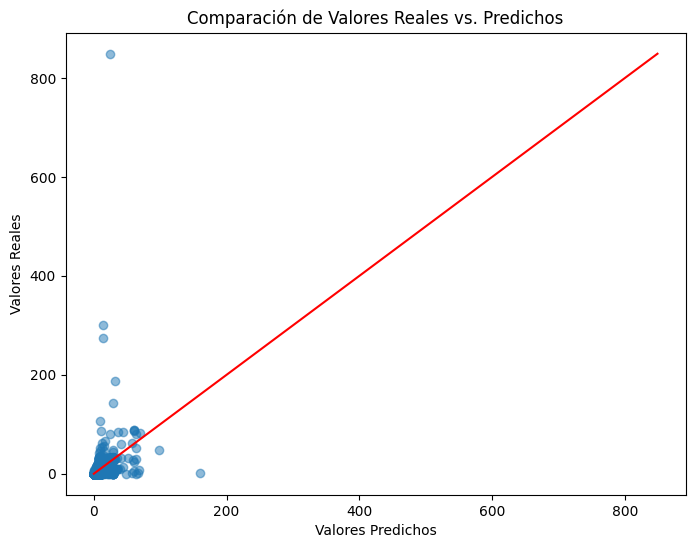

In [34]:
plot_predictions_vs_actual(y_test,y_pred_forest)

In [35]:
# Modifico la grafica para ignorar los outliers:

def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

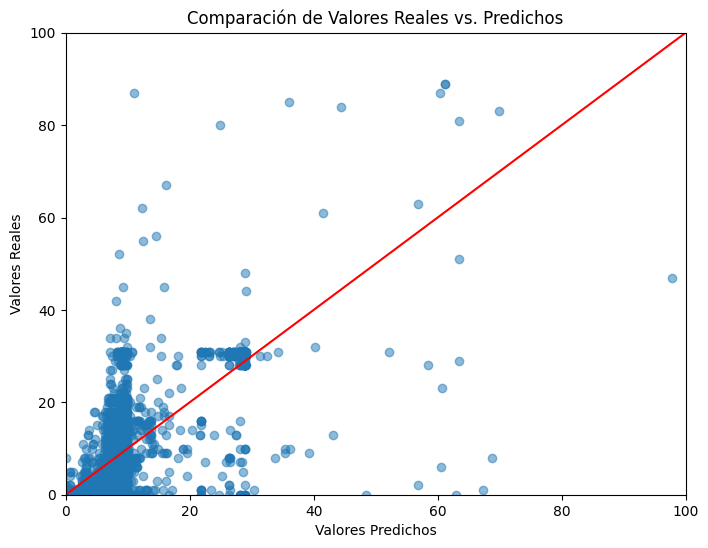

In [36]:
plot_predictions_vs_actual(y_test,y_pred_forest)

---> Vamos a ver si con el Fine-Tunning arreglamos esto.